In [ ]:
#Importing all the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
#Keras
import keras
import keras.backend as K 
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from keras.layers import  Conv2D, MaxPooling2D, GlobalAveragePooling2D,Conv2DTranspose
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import load_model
#Scikit-Learn
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/DeepLearning/datasets/lol_dataset.zip

In [ ]:
!rm -r /content/lol_dataset/our485/low/.ipynb_checkpoints

rm: cannot remove '/content/lol_dataset/our485/low/.ipynb_checkpoints': No such file or directory


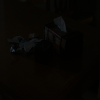

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

training_before_noise = []
path = os.path.join("/content/lol_dataset/our485", 'low')
images = [img for img in os.listdir(path) if img.endswith(".png")]
for img in images:
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, (100, 100), interpolation=cv2.INTER_AREA)
    training_before_noise.append(new_array)

cv2_imshow(training_before_noise[0])

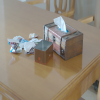

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

training_after = []
path = os.path.join("/content/lol_dataset/our485", 'high')
images = [img for img in os.listdir(path) if img.endswith(".png")]
for img in images:
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, (100, 100), interpolation=cv2.INTER_AREA)
    training_after.append(new_array)

cv2_imshow(training_after[0])

In [ ]:
training_before_noise1 = np.stack(training_before_noise).astype('uint8')
training_after1 = np.stack(training_after).astype('uint8')

In [ ]:
train=training_before_noise1.astype('float32') / 255.0 - 0.5
test=training_after1.astype('float32') / 255.0 - 0.5

In [ ]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

Epoch 1/100
16/16 [==============================] - 7s 416ms/step - loss: 0.1771 - val_loss: 0.1739
Epoch 2/100
16/16 [==============================] - 5s 333ms/step - loss: 0.1740 - val_loss: 0.1730
Epoch 3/100
16/16 [==============================] - 5s 342ms/step - loss: 0.1730 - val_loss: 0.1733
Epoch 4/100
16/16 [==============================] - 5s 347ms/step - loss: 0.1745 - val_loss: 0.1725
Epoch 5/100
16/16 [==============================] - 7s 422ms/step - loss: 0.1723 - val_loss: 0.1716
Epoch 6/100
16/16 [==============================] - 7s 424ms/step - loss: 0.1709 - val_loss: 0.1692
Epoch 7/100
16/16 [==============================] - 6s 416ms/step - loss: 0.1698 - val_loss: 0.1691
Epoch 8/100
16/16 [==============================] - 6s 411ms/step - loss: 0.1686 - val_loss: 0.1664
Epoch 9/100
16/16 [==============================] - 5s 337ms/step - loss: 0.1667 - val_loss: 0.1644
Epoch 10/100
16/16 [==============================] - 6s 412ms/step - loss: 0.1653 - val_lo

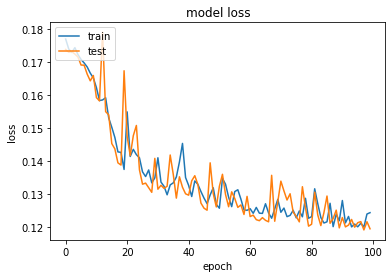

In [ ]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # encoder
    encoder = Sequential()
    encoder.add(Input(img_shape))
    encoder.add(Conv2D(256, (3, 3), activation= 'LeakyReLU', strides=1, padding='same'))
    encoder.add(Conv2D(128, (3, 3), activation= 'LeakyReLU', strides=1, padding='same'))

    # decoder
    decoder = Sequential()
    decoder.add(Conv2DTranspose(128, kernel_size=3, strides=1, activation='LeakyReLU', padding='same'))
    decoder.add(Conv2DTranspose(256, kernel_size=3, strides=1, activation='LeakyReLU', padding='same'))
    decoder.add(Conv2D(3, kernel_size=(3, 3),activation='LeakyReLU', padding= 'same'))

    return encoder, decoder


IMG_SHAPE = train.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 256)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)

def loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


autoencoder.compile(optimizer=optimizer, loss=loss)


history = autoencoder.fit(x=train, y=test, epochs=100,
                validation_data=[train, test])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

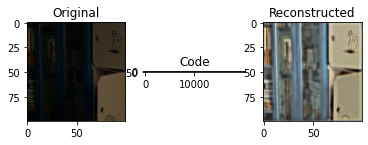

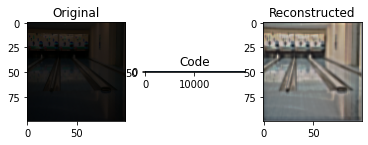

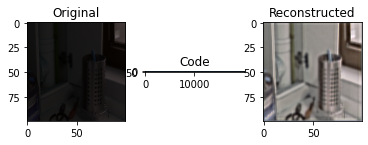

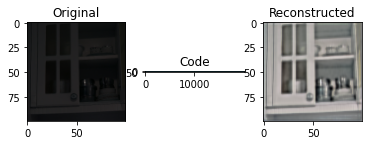

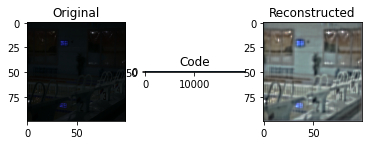

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

test_final = []
path = os.path.join("/content/lol_dataset/eval15", 'low')
images = [img for img in os.listdir(path) if img.endswith(".png")]
for img in images:
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, (100, 100), interpolation=cv2.INTER_AREA)
    test_final.append(new_array)

test_final = np.stack(test_final).astype('uint8')
test_final=test_final.astype('float32') / 255.0 - 0.5



def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = test_final[i]
    visualize(img,encoder,decoder)

In [ ]:
img_array = cv2.imread("/content/lol_dataset/eval15/low/1.png")
new_array = cv2.resize(img_array, (100, 100), interpolation=cv2.INTER_AREA)
new_array=np.stack(new_array).astype('uint8')
new_array=new_array.astype('float32') / 255.0 - 0.5


code = encoder.predict(new_array[None])[0]
reco = decoder.predict(code[None])[0]

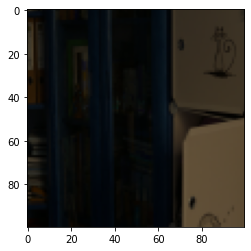

In [ ]:
#orginal
show_image(new_array)

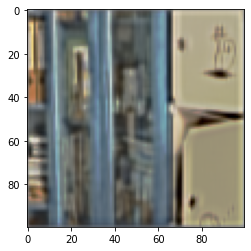

In [ ]:
#decoder
show_image(reco)